In [150]:
import pandas as pd
from matplotlib.figure import Figure
import pymysql
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from copy import copy

In [114]:
#建立连接
conn = pymysql.connect(
	host="114.116.114.149",
	port=10022,
	user="exomics_admin",
	passwd="exomics_2022",
	db='exOmics'
)

#设定要查询的数据类型和基因
gene = 'ENSG00000000457' #基因主页所对应的基因
feature = 'altp' #此处值是范例，实际上需要根据网页决定
dataset = 'gse68086' #此处值是范例，实际上需要根据网页决定
specimen = 'tep' #此处值是范例，实际上需要根据网页决定

#以下变量由上述选择自动决定，因为具有关联性
molecule = 'cfrna'
entity = 'entity'
value = 'count'

#根据以上条件查询所有可能的疾病类型
sql_disease = f"""
	SELECT ori.Disease_condition
	FROM (
        SELECT SUBSTRING_INDEX(TABLE_NAME,'-',1) AS NT,
			SUBSTRING_INDEX(SUBSTRING_INDEX(TABLE_NAME,'-',-6),'-',1) AS Omics,
			SUBSTRING_INDEX(SUBSTRING_INDEX(TABLE_NAME,'-',-5),'-',1) AS Dataset,
			SUBSTRING_INDEX(SUBSTRING_INDEX(TABLE_NAME,'-',-4),'-',1) AS Entity,
			SUBSTRING_INDEX(SUBSTRING_INDEX(TABLE_NAME,'-',-3),'-',1) AS Disease_condition,
			SUBSTRING_INDEX(SUBSTRING_INDEX(TABLE_NAME,'-',-2),'-',1) AS Specimen,
			SUBSTRING_INDEX(TABLE_NAME,'-',-1) AS Value_type
		FROM information_schema.`TABLES`
		WHERE table_schema='exOmics'
    		AND (
                TABLE_NAME LIKE '%gse%'
				OR TABLE_NAME LIKE '%prjeb%'
				OR TABLE_NAME LIKE '%prjna%'
				OR TABLE_NAME LIKE '%gse%'
				OR TABLE_NAME LIKE '%srp%'
				OR TABLE_NAME LIKE '%pxd%'
            )
            AND TABLE_NAME NOT LIKE '%gsea%'
        )ori
	WHERE Dataset LIKE '%{dataset}%'
		AND Omics LIKE '%{feature}%'
        AND Disease_condition NOT LIKE '%mean%'
"""
diseases = pd.read_sql_query(sql_disease, conn)

In [87]:
diseases

,Disease_condition
0,brca
1,crc
2,ct
3,gbm
4,lihc
5,luca
6,paad


In [116]:
#查询语句
diseases_data = {}
for disease in diseases['Disease_condition']:
	query_sql = f"""
		SELECT c.*
		FROM `{molecule}-{feature}-{dataset}-{entity}-{disease}-{specimen}-{value}` c, gene_index g
		WHERE c.feature LIKE CONCAT('%',g.ensembl_gene_id,'%')
			AND g.ensembl_gene_id LIKE '%{gene}%'
	"""
	temp = pd.read_sql_query(query_sql, conn) #选择某个疾病类型下的某个基因的所有样本的值，应当是1*n的矩阵
	fentities = list(temp['feature'])
	for fentity in fentities:
		if fentity not in diseases_data.keys():
			diseases_data[fentity] = {}
		diseases_data[fentity][disease.upper()] = list(temp[temp['feature']==fentity].iloc[0,1:].astype('float'))


/Users/limingyang/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/limingyang/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/limingyang/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/limingyang/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQL

In [117]:
diseases_data

{'ENSG00000000457.13|SCYL3|protein_coding|2916|169888888.-': {'BRCA': [0.421755,
   0.0,
   0.380843,
   0.0,
   0.0,
   0.961586,
   0.43226,
   0.0,
   0.785898,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.098836,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.308603,
   0.0,
   0.343505,
   0.0,
   0.0,
   0.544936,
   0.093856,
   0.0,
   0.0,
   0.0,
   0.0],
  'CRC': [0.0,
   0.0,
   0.0,
   0.0,
   0.268301,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.840412,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0],
  'CT': [0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.040496,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   3.628547,
   0.0,
   0.317475,
   0.0,
   0.113454,
   0.0,
   0.70494,
   3.2904120000000

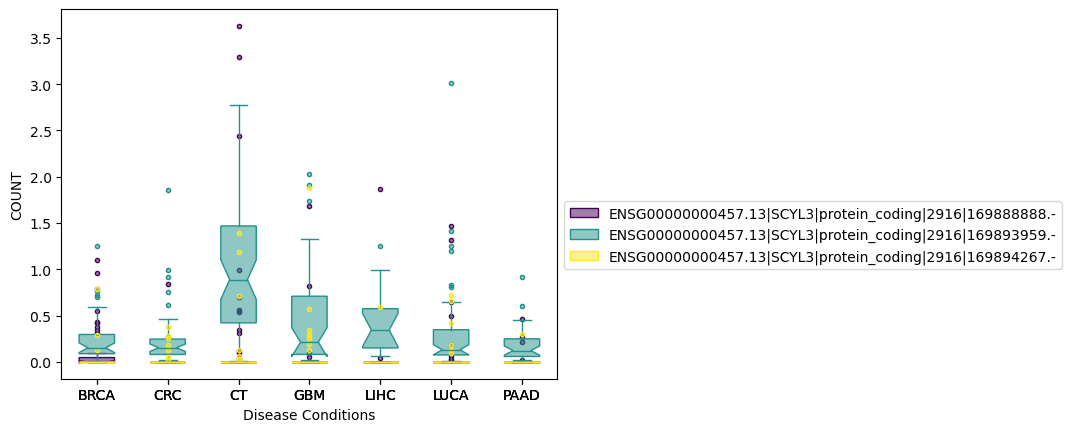

In [184]:
features, out_data = diseases_data.keys(), diseases_data.values()
fig = Figure()
ax = fig.subplots()
cmap = cm.get_cmap('viridis',len(features))
colors = cmap(np.linspace(0, 1, len(features)))
colors[:,-1] = 0.5
elements = []
for i in range(len(features)): #对于每个entity
    feature = list(features)[i]
    labels, data = diseases_data[feature].keys(), diseases_data[feature].values()
    color = colors[i,:]
    color_notrans = copy(color)
    color_notrans[-1] = 1
    elements.append(ax.boxplot(data,
        notch=True,
        patch_artist=True,
        labels=labels,
        boxprops={'facecolor':color,'edgecolor':color_notrans},
        flierprops={'marker':'.', 'markerfacecolor': color, 'markeredgecolor': color_notrans},
        medianprops = {'color': color_notrans},
        capprops={'color':color_notrans},
        whiskerprops={'color':color_notrans}))
    ax.set_xlabel('Disease Conditions')
    ax.set_ylabel(f'{value.upper()}')
colors_notrans = copy(colors)
colors_notrans[:,-1] = 1
ax.legend([element["boxes"][0] for element in elements],
    [list(features)[idx] for idx in range(len(features))],
    bbox_to_anchor=(1, 0.5),
    loc='best'
)
fig

In [146]:
colors = cmap(np.linspace(0, 1, len(features)))
colors[:,-1] = 0.5
colors

array([[0.267004, 0.004874, 0.329415, 0.5     ],
       [0.127568, 0.566949, 0.550556, 0.5     ],
       [0.993248, 0.906157, 0.143936, 0.5     ]])

In [148]:
colors

array([[0.267004, 0.004874, 0.329415, 1.      ],
       [0.127568, 0.566949, 0.550556, 1.      ],
       [0.993248, 0.906157, 0.143936, 1.      ]])

In [135]:
cmap = cm.get_cmap('viridis',len(features))
colors = cmap(np.linspace(0, 1, len(features)))
colors[:,-1] = 0.5
a = colors[1,:]
a[-1] = 1
a

array([0.127568, 0.566949, 0.550556, 1.      ])